['86194da67ffffff', '86194da6fffffff', '861fa4027ffffff', '861fa4157ffffff', '861fa4597ffffff', '861fa45b7ffffff', '861fa686fffffff']


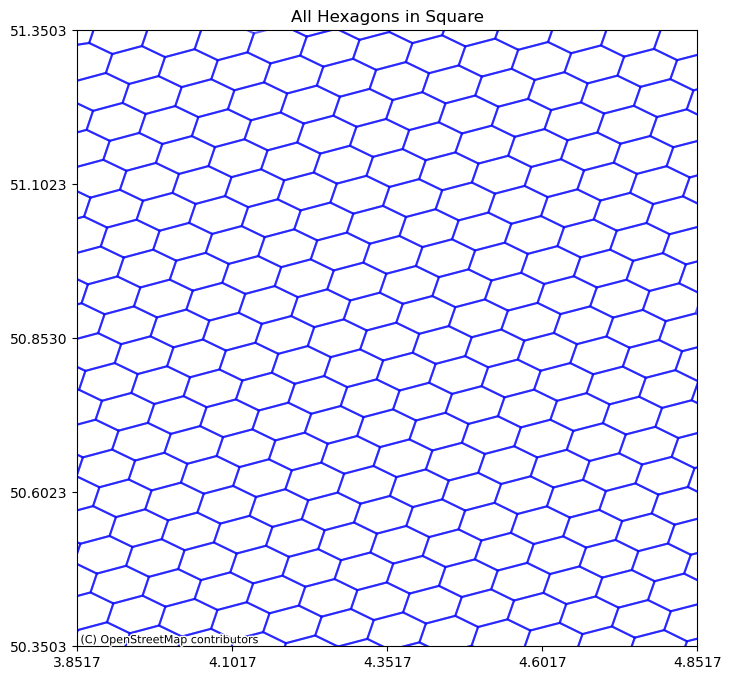

In [2]:
import h3
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
from matplotlib.animation import FuncAnimation
import contextily as ctx
from pyproj import Transformer
import pandas as pd
from collections import defaultdict

# Coordinate transformation from WGS84 to Web Mercator (EPSG:3857)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

# Coordinate transformation from Web Mercator back to WGS84
inverse_transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)

def draw_h3_hexagons(lat, lon, resolution):
    """
    Generates a hexagonal polygon using the H3 library based on latitude, longitude, and resolution.
    """
    h3_index = h3.latlng_to_cell(lat, lon, resolution)
    hex_boundary = h3.cell_to_boundary(h3_index)
    hex_boundary = [(lng, lat) for lat, lng in hex_boundary]  # Swap for (lon, lat)
    return Polygon(hex_boundary), h3_index

def generate_random_points(lat, lon, offset, count=10):
    """Generates random points within a bounding box."""
    lats = np.random.uniform(lat - offset/2, lat + offset/2, count)
    lons = np.random.uniform(lon - offset/2, lon + offset/2, count)
    return list(zip(lons, lats))

def generate_hexagons_in_square(lat, lon, side_length, resolution):
    """
    Generates a set of hexagons that fill a square polygon with a given side length.
    The square is centered around the given lat, lon.
    """
    hexagons = {}
    # Calculate the corners of the square (approximately in degrees)
    lat_min = lat - side_length / 2
    lat_max = lat + side_length / 2
    lon_min = lon - side_length / 2
    lon_max = lon + side_length / 2

    # Start by creating a grid of hexagons that fit within the square
    step_size = 0.005  # Smaller step size to ensure more coverage
    for lat_offset in np.arange(lat_min, lat_max, step_size):
        for lon_offset in np.arange(lon_min, lon_max, step_size):
            hex_poly, h3_index = draw_h3_hexagons(lat_offset, lon_offset, resolution)
            hexagons[h3_index] = hex_poly

    return hexagons

def animate_h3_hexagons(lat, lon, side_length, resolution, num_points):
    """Animates different stages of H3 hexagon visualization."""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("H3 Hexagon Analysis")

    # Generate hexagons within a square
    base_hexes = generate_hexagons_in_square(lat, lon, side_length, resolution)

    # Generate random points
    points = generate_random_points(lat, lon, offset=side_length, count=num_points)

    # Create a dataframe for points and their corresponding hexagons
    points_df = pd.DataFrame(points, columns=["lon", "lat"])
    points_df["h3_index_original"] = points_df.apply(lambda row: h3.latlng_to_cell(row["lat"], row["lon"], resolution), axis=1)
    points_df.loc[:,'h3_nb_index'] = points_df.h3_index_original.apply(lambda l: set(h3.grid_disk(l, 1)))
    neighbours_df = points_df.explode('h3_nb_index')
    neighbours_df_count = neighbours_df.groupby('h3_nb_index').count().reset_index()
    neighbours_df_count_f = neighbours_df_count[neighbours_df_count.h3_index_original >= 2]

    original_hexes = points_df.h3_index_original.to_list()
    neighbour_hexes = neighbours_df.h3_nb_index.to_list()
    overlapping_hexes = neighbours_df_count_f.h3_nb_index.to_list()

    neighbours_df_f = neighbours_df[
            neighbours_df.h3_nb_index.isin(overlapping_hexes)].drop_duplicates()

    print(overlapping_hexes)
    neighbour_hexes = [x for x in neighbour_hexes if x in base_hexes.keys()]
    overlapping_hexes = [x for x in overlapping_hexes if x in base_hexes.keys()]

    frames = ["all_hex", "random_points", "hex_with_points", "hex_neighbors", "hex_overlapping_neighbors" , "overlapping_hexes", "final_hex_points"]

    def update(frame, lat=lat, lon=lon, offset=1):
        ax.clear()

        # Add basemap with a valid zoom level
        ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.OpenStreetMap.Mapnik, zoom=5)

        # Set the limits based on the transformed coordinates
        offset_d = offset / 2
        ax.set_xlim(transformer.transform(lon - offset_d, lat - offset_d)[0], transformer.transform(lon + offset_d, lat + offset_d)[0])
        ax.set_ylim(transformer.transform(lon - offset_d, lat - offset_d)[1], transformer.transform(lon + offset_d, lat + offset_d)[1])

        # Set correct lat/lon ticks on the axis
        x_ticks = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], num=5)
        y_ticks = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], num=5)

        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)

        # Transform ticks from Web Mercator to Lat/Lon
        lon_ticks, lat_ticks = zip(*[inverse_transformer.transform(x, y) for x, y in zip(x_ticks, y_ticks)])
        ax.set_xticklabels([f"{lon:.4f}" for lon in lon_ticks])
        ax.set_yticklabels([f"{lat:.4f}" for lat in lat_ticks])

        if frames[frame] == "all_hex":
            for hex_poly in base_hexes.values():
                x, y = zip(*[transformer.transform(*coord) for coord in hex_poly.exterior.coords])
                ax.plot(x, y, "blue", alpha=0.6)
            ax.set_title("All Hexagons in Square")

        elif frames[frame] == "random_points":
            for hex_poly in base_hexes.values():
                x, y = zip(*[transformer.transform(*coord) for coord in hex_poly.exterior.coords])
                ax.plot(x, y, "blue", alpha=0.6)
            for lon, lat in points:
                x, y = transformer.transform(lon, lat)
                ax.scatter(x, y, color="black")
            ax.set_title("Randomly Generated Points")

        elif frames[frame] == "hex_with_points":
            for lon, lat in points:
                x, y = transformer.transform(lon, lat)
                ax.scatter(x, y, color="black")
            for h3_index in original_hexes:
                x, y = zip(*[transformer.transform(*coord) for coord in base_hexes[h3_index].exterior.coords])
                ax.plot(x, y, "green")
            ax.set_title("Hexagons Containing Points")

        elif frames[frame] == "hex_neighbors":
            for lon, lat in points:
                x, y = transformer.transform(lon, lat)
                ax.scatter(x, y, color="black")
            for h3_index in neighbour_hexes:
                x, y = zip(*[transformer.transform(*coord) for coord in base_hexes[h3_index].exterior.coords])
                ax.plot(x, y, "orange")
            for h3_index in original_hexes:
                x, y = zip(*[transformer.transform(*coord) for coord in base_hexes[h3_index].exterior.coords])
                ax.plot(x, y, "green")
            ax.set_title("Neighboring Hexagons of Point-Holding Hexagons")

        elif frames[frame] == "hex_overlapping_neighbors":
            for lon, lat in points:
                x, y = transformer.transform(lon, lat)
                ax.scatter(x, y, color="black")
            for h3_index in neighbour_hexes:
                x, y = zip(*[transformer.transform(*coord) for coord in base_hexes[h3_index].exterior.coords])
                ax.plot(x, y, "orange")
            for h3_index in overlapping_hexes:
                x, y = zip(*[transformer.transform(*coord) for coord in base_hexes[h3_index].exterior.coords])
                ax.plot(x, y, "red")
            for h3_index in original_hexes:
                x, y = zip(*[transformer.transform(*coord) for coord in base_hexes[h3_index].exterior.coords])
                ax.plot(x, y, "green")
            ax.set_title("Neighboring Hexagons of Point-Holding Hexagons")

        elif frames[frame] == "overlapping_hexes":
            for lon, lat in points:
                x, y = transformer.transform(lon, lat)
                ax.scatter(x, y, color="black")
            for h3_index in overlapping_hexes:
                x, y = zip(*[transformer.transform(*coord) for coord in base_hexes[h3_index].exterior.coords])
                ax.plot(x, y, "red")
            for h3_index in original_hexes:
                x, y = zip(*[transformer.transform(*coord) for coord in base_hexes[h3_index].exterior.coords])
                ax.plot(x, y, "green")
            
            ax.set_title("Overlapping Hexagons (Original + Neighboring) Highlighted in Red")

        elif frames[frame] == "final_hex_points":
            for lon, lat in zip(*[neighbours_df_f.lon.to_list(),neighbours_df_f.lat.to_list()]):
                x, y = transformer.transform(lon, lat)
                ax.scatter(x, y, color="black")
            for h3_index in overlapping_hexes:
                x, y = zip(*[transformer.transform(*coord) for coord in base_hexes[h3_index].exterior.coords])
                ax.plot(x, y, "red")
            for h3_index in neighbours_df_f.h3_index_original.unique():
                x, y = zip(*[transformer.transform(*coord) for coord in base_hexes[h3_index].exterior.coords])
                ax.plot(x, y, "green")
            ax.set_title("Final Hexagons and Overlapping Points")

    ani = FuncAnimation(fig, update, frames=len(frames), repeat=True)
    return ani

# Example usage
latitude = 50.8503  # Brussels
longitude = 4.3517
side_length = 1  # Side length of the square (in degrees)
points = 12

ani = animate_h3_hexagons(latitude, longitude, side_length, resolution=6, num_points=points)

# Display animation in Jupyter Notebook
from IPython.display import HTML
HTML(ani.to_jshtml())